This notebook tests on applying bagging over small convolutional networks.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, utils
import matplotlib.pyplot as plt

print(tf.__version__) # 2.10.0

utils.set_random_seed(812)

2.10.0


Dataset used: MNIST, Fashion MNIST, CIFAR-10. Datasets are normalized so that the values lie between 0 and 1.

In [2]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = datasets.mnist.load_data()
mnist_train_images = mnist_train_images / 255.0
mnist_test_images = mnist_test_images / 255.0
print(mnist_train_images.shape, mnist_train_labels.shape, mnist_test_images.shape, mnist_test_labels.shape)

(fmnist_train_images, fmnist_train_labels), (fmnist_test_images, fmnist_test_labels) = datasets.fashion_mnist.load_data()
fmnist_train_images = fmnist_train_images / 255.0
fmnist_test_images = fmnist_test_images / 255.0
print(fmnist_train_images.shape, fmnist_test_images.shape, fmnist_train_labels.shape, fmnist_test_labels.shape)


(cifar_train_images, cifar_train_labels), (cifar_test_images, cifar_test_labels) = datasets.cifar10.load_data()
cifar_train_images = cifar_train_images / 255.0
cifar_test_images = cifar_test_images / 255.0
print(cifar_train_images.shape, cifar_train_labels.shape, cifar_test_images.shape, cifar_test_labels.shape)



(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# Training the base learner
The following functions outputs a base CNN model. For MNIST and Fashion MNIST, there is one convolutional layer with 32 filters, followed by a max-pooling layer and a dense layer; For CIFAR-10, there are two convolutional layer, each followed by a max-pooling layer, and a dense layer at last. The models are trained through SGD with cross-entropy loss. Early-stopping is applied based on validation accuracy. <br>
The output of these CNNs are logits instead of probabilities.

In [3]:
def train_base_model(dataset_name, train_images, train_labels):
    history = None
    model = models.Sequential()
    if dataset_name == 'mnist':
        model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=(28, 28, 1)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=10))
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) 
        history = model.fit(train_images, train_labels, epochs=50,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4, min_delta=0.001)], 
              batch_size=75, 
              verbose=2) # Default batch size is 32
    elif dataset_name == 'fashion_mnist':
        model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=(28, 28, 1)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=10))
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) 
        history = model.fit(train_images, train_labels, epochs=50,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4, min_delta=0.001)], 
              batch_size=75, 
              verbose=2) 
    elif dataset_name == 'cifar10':
        model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=(32, 32, 3)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=10))
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) 
        history = model.fit(train_images, train_labels, epochs=50,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4, min_delta=0.001)], 
              batch_size=75, 
              verbose=2) 
    return model, history

# Training bagging models
`bagging_train()` trains a bagging model with `num_models` base learners using `num_examples` random examples from the training set. The resulting model would be a list of CNN networks. `bagging_test()` tests the model and returns the training and test losses as well as accuracies. <br>
The bagging model makes a prediction by taking the average of the logits from each base learners.

In [4]:
def bagging_train(num_models, num_examples, train_images, train_labels, dataset_name):
    
    bagging_model = []
    histories = []
    
    for i in range(num_models):
        # Generate a subset of training examples
        indices = np.random.choice(train_images.shape[0], num_examples, replace=False)
        train_images_subset = train_images[indices]
        train_labels_subset = train_labels[indices]
        
        base_model, history = train_base_model(dataset_name, train_images_subset, train_labels_subset)
        bagging_model.append(base_model)
        histories.append(history)
        
    return bagging_model, histories

def bagging_test(bagging_model, train_images, train_labels, test_images, test_labels):
    train_predictions = np.empty(len(bagging_model), dtype=object)
    test_predictions = np.empty(len(bagging_model), dtype=object)
        
    for i, base_model in enumerate(bagging_model):
        train_predictions[i] = base_model.predict(train_images, verbose=2)
        test_predictions[i] = base_model.predict(test_images, verbose=2)
        
    train_output = np.mean(train_predictions, axis=0)
    test_output = np.mean(test_predictions, axis=0)
    
    cross_entropy_tr = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    train_loss = cross_entropy_tr(train_labels, train_output).numpy()
    categorical_accuracy_tr = tf.keras.metrics.SparseCategoricalAccuracy()
    categorical_accuracy_tr.update_state(train_labels, train_output)
    train_accuracy = categorical_accuracy_tr.result().numpy()
    
    cross_entropy_te = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    test_loss = cross_entropy_te(test_labels, test_output).numpy()
    categorical_accuracy_te = tf.keras.metrics.SparseCategoricalAccuracy()
    categorical_accuracy_te.update_state(test_labels, test_output)
    test_accuracy = categorical_accuracy_te.result().numpy()
    
    return train_loss, train_accuracy, test_loss, test_accuracy



For each of the following experiments, a base CNN model and a bagging model is trained; The bagging model have 5 base model, each trained with half of the training set.

# MNIST


In [5]:
train_images = mnist_train_images
train_labels = mnist_train_labels
test_images = mnist_test_images
test_labels = mnist_test_labels


cnn_model = train_base_model('mnist', train_images, train_labels)[0]

train_loss, train_accuracy = cnn_model.evaluate(train_images, train_labels, verbose=2) 
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels, verbose=2)
print("Training loss:", train_loss)
print("Test loss:", test_loss)
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)



Epoch 1/50
640/640 - 3s - loss: 0.4829 - sparse_categorical_accuracy: 0.8605 - val_loss: 0.3101 - val_sparse_categorical_accuracy: 0.9109 - 3s/epoch - 5ms/step
Epoch 2/50
640/640 - 3s - loss: 0.2979 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.2473 - val_sparse_categorical_accuracy: 0.9286 - 3s/epoch - 4ms/step
Epoch 3/50
640/640 - 3s - loss: 0.2385 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.2076 - val_sparse_categorical_accuracy: 0.9434 - 3s/epoch - 5ms/step
Epoch 4/50
640/640 - 3s - loss: 0.1853 - sparse_categorical_accuracy: 0.9477 - val_loss: 0.1509 - val_sparse_categorical_accuracy: 0.9604 - 3s/epoch - 4ms/step
Epoch 5/50
640/640 - 3s - loss: 0.1456 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.1279 - val_sparse_categorical_accuracy: 0.9659 - 3s/epoch - 5ms/step
Epoch 6/50
640/640 - 3s - loss: 0.1203 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.1146 - val_sparse_categorical_accuracy: 0.9688 - 3s/epoch - 4ms/step
Epoch 7/50
640/640 - 3s - loss: 0.1038 -

In [6]:
bagging_model = bagging_train(5, 30000, train_images, train_labels, 'mnist')[0]
train_loss, train_accuracy, test_loss, test_accuracy = bagging_test(bagging_model, train_images, train_labels, test_images, test_labels)
print("Training loss:", train_loss)
print("Test loss:", test_loss)
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)


Epoch 1/50
320/320 - 2s - loss: 0.5978 - sparse_categorical_accuracy: 0.8290 - val_loss: 0.3628 - val_sparse_categorical_accuracy: 0.8927 - 2s/epoch - 6ms/step
Epoch 2/50
320/320 - 3s - loss: 0.3337 - sparse_categorical_accuracy: 0.9008 - val_loss: 0.3339 - val_sparse_categorical_accuracy: 0.9003 - 3s/epoch - 9ms/step
Epoch 3/50
320/320 - 1s - loss: 0.2990 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.3043 - val_sparse_categorical_accuracy: 0.9127 - 1s/epoch - 4ms/step
Epoch 4/50
320/320 - 1s - loss: 0.2718 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.2866 - val_sparse_categorical_accuracy: 0.9123 - 1s/epoch - 4ms/step
Epoch 5/50
320/320 - 1s - loss: 0.2439 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.2504 - val_sparse_categorical_accuracy: 0.9242 - 1s/epoch - 4ms/step
Epoch 6/50
320/320 - 1s - loss: 0.2151 - sparse_categorical_accuracy: 0.9393 - val_loss: 0.2292 - val_sparse_categorical_accuracy: 0.9320 - 1s/epoch - 4ms/step
Epoch 7/50
320/320 - 1s - loss: 0.1899 -

# Fashion MNIST

In [7]:
train_images = fmnist_train_images
train_labels = fmnist_train_labels
test_images = fmnist_test_images
test_labels = fmnist_test_labels


cnn_model = train_base_model('fashion_mnist', train_images, train_labels)[0]

train_loss, train_accuracy = cnn_model.evaluate(train_images, train_labels, verbose=2)
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels, verbose=2)
print("Training loss:", train_loss)
print("Test loss:", test_loss)
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)



Epoch 1/50
640/640 - 3s - loss: 0.7117 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.5111 - val_sparse_categorical_accuracy: 0.8203 - 3s/epoch - 5ms/step
Epoch 2/50
640/640 - 3s - loss: 0.4680 - sparse_categorical_accuracy: 0.8365 - val_loss: 0.4140 - val_sparse_categorical_accuracy: 0.8548 - 3s/epoch - 5ms/step
Epoch 3/50
640/640 - 4s - loss: 0.4088 - sparse_categorical_accuracy: 0.8584 - val_loss: 0.4030 - val_sparse_categorical_accuracy: 0.8577 - 4s/epoch - 7ms/step
Epoch 4/50
640/640 - 3s - loss: 0.3746 - sparse_categorical_accuracy: 0.8704 - val_loss: 0.3682 - val_sparse_categorical_accuracy: 0.8706 - 3s/epoch - 5ms/step
Epoch 5/50
640/640 - 3s - loss: 0.3523 - sparse_categorical_accuracy: 0.8788 - val_loss: 0.3522 - val_sparse_categorical_accuracy: 0.8769 - 3s/epoch - 4ms/step
Epoch 6/50
640/640 - 3s - loss: 0.3363 - sparse_categorical_accuracy: 0.8836 - val_loss: 0.3586 - val_sparse_categorical_accuracy: 0.8722 - 3s/epoch - 4ms/step
Epoch 7/50
640/640 - 3s - loss: 0.3228 -

In [8]:
bagging_model = bagging_train(5, 30000, train_images, train_labels, 'fashion_mnist')[0]
train_loss, train_accuracy, test_loss, test_accuracy = bagging_test(bagging_model, train_images, train_labels, test_images, test_labels)
print("Training loss:", train_loss)
print("Test loss:", test_loss)
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)


Epoch 1/50
320/320 - 2s - loss: 0.8747 - sparse_categorical_accuracy: 0.7078 - val_loss: 0.6401 - val_sparse_categorical_accuracy: 0.7768 - 2s/epoch - 6ms/step
Epoch 2/50
320/320 - 1s - loss: 0.5643 - sparse_categorical_accuracy: 0.8040 - val_loss: 0.7146 - val_sparse_categorical_accuracy: 0.7595 - 1s/epoch - 4ms/step
Epoch 3/50
320/320 - 1s - loss: 0.4908 - sparse_categorical_accuracy: 0.8278 - val_loss: 0.4740 - val_sparse_categorical_accuracy: 0.8273 - 1s/epoch - 4ms/step
Epoch 4/50
320/320 - 2s - loss: 0.4485 - sparse_categorical_accuracy: 0.8403 - val_loss: 0.4616 - val_sparse_categorical_accuracy: 0.8308 - 2s/epoch - 5ms/step
Epoch 5/50
320/320 - 2s - loss: 0.4191 - sparse_categorical_accuracy: 0.8544 - val_loss: 0.4203 - val_sparse_categorical_accuracy: 0.8460 - 2s/epoch - 6ms/step
Epoch 6/50
320/320 - 1s - loss: 0.3968 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.4005 - val_sparse_categorical_accuracy: 0.8550 - 1s/epoch - 4ms/step
Epoch 7/50
320/320 - 1s - loss: 0.3797 -

# CIFAR-10

In [9]:
train_images = cifar_train_images
train_labels = cifar_train_labels
test_images = cifar_test_images
test_labels = cifar_test_labels


cnn_model, cnn_history = train_base_model('cifar10', train_images, train_labels)

train_loss, train_accuracy = cnn_model.evaluate(train_images, train_labels, verbose=2)
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels, verbose=2)
print("Training loss:", train_loss)
print("Test loss:", test_loss)
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)


Epoch 1/50
534/534 - 6s - loss: 1.9356 - sparse_categorical_accuracy: 0.3060 - val_loss: 1.6719 - val_sparse_categorical_accuracy: 0.3985 - 6s/epoch - 12ms/step
Epoch 2/50
534/534 - 5s - loss: 1.5499 - sparse_categorical_accuracy: 0.4504 - val_loss: 1.4571 - val_sparse_categorical_accuracy: 0.4892 - 5s/epoch - 10ms/step
Epoch 3/50
534/534 - 5s - loss: 1.3839 - sparse_categorical_accuracy: 0.5135 - val_loss: 1.3429 - val_sparse_categorical_accuracy: 0.5307 - 5s/epoch - 10ms/step
Epoch 4/50
534/534 - 5s - loss: 1.2699 - sparse_categorical_accuracy: 0.5549 - val_loss: 1.2769 - val_sparse_categorical_accuracy: 0.5466 - 5s/epoch - 10ms/step
Epoch 5/50
534/534 - 5s - loss: 1.1892 - sparse_categorical_accuracy: 0.5832 - val_loss: 1.2508 - val_sparse_categorical_accuracy: 0.5614 - 5s/epoch - 10ms/step
Epoch 6/50
534/534 - 5s - loss: 1.1236 - sparse_categorical_accuracy: 0.6115 - val_loss: 1.4848 - val_sparse_categorical_accuracy: 0.4728 - 5s/epoch - 10ms/step
Epoch 7/50
534/534 - 5s - loss: 1.

In [10]:
bagging_model, base_histories = bagging_train(5, 25000, train_images, train_labels, 'cifar10')
train_loss, train_accuracy, test_loss, test_accuracy = bagging_test(bagging_model, train_images, train_labels, test_images, test_labels)
print("Training loss:", train_loss)
print("Test loss:", test_loss)
print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)


Epoch 1/50
267/267 - 3s - loss: 2.1196 - sparse_categorical_accuracy: 0.2185 - val_loss: 1.9141 - val_sparse_categorical_accuracy: 0.3112 - 3s/epoch - 12ms/step
Epoch 2/50
267/267 - 3s - loss: 1.8283 - sparse_categorical_accuracy: 0.3528 - val_loss: 1.7852 - val_sparse_categorical_accuracy: 0.3790 - 3s/epoch - 9ms/step
Epoch 3/50
267/267 - 3s - loss: 1.6348 - sparse_categorical_accuracy: 0.4232 - val_loss: 1.6707 - val_sparse_categorical_accuracy: 0.4166 - 3s/epoch - 10ms/step
Epoch 4/50
267/267 - 3s - loss: 1.5036 - sparse_categorical_accuracy: 0.4645 - val_loss: 1.4700 - val_sparse_categorical_accuracy: 0.4794 - 3s/epoch - 10ms/step
Epoch 5/50
267/267 - 3s - loss: 1.4212 - sparse_categorical_accuracy: 0.4969 - val_loss: 1.4366 - val_sparse_categorical_accuracy: 0.4972 - 3s/epoch - 10ms/step
Epoch 6/50
267/267 - 3s - loss: 1.3483 - sparse_categorical_accuracy: 0.5261 - val_loss: 1.3524 - val_sparse_categorical_accuracy: 0.5192 - 3s/epoch - 10ms/step
Epoch 7/50
267/267 - 3s - loss: 1.2

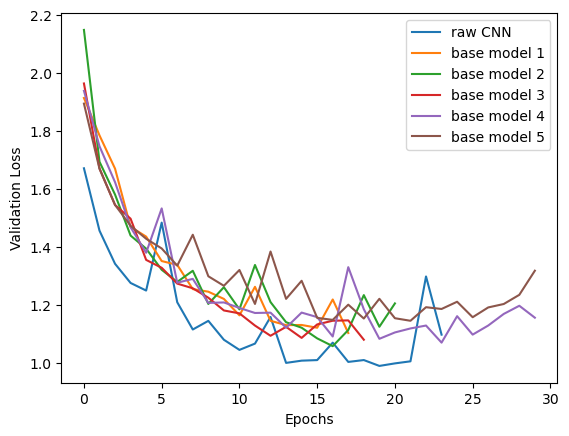

In [11]:
x_axis = np.arange(50)
y_axis = cnn_history.history['val_loss']
y_axis = y_axis + [np.nan] * (50 - len(y_axis))
plt.plot(x_axis, y_axis, label='raw CNN')
for i, history in enumerate(base_histories):
    y_axis = history.history['val_loss']
    y_axis = y_axis + [np.nan] * (50 - len(y_axis))
    plt.plot(x_axis, y_axis, label='base model ' + str(i+1))
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(loc='best')
plt.show() 